In [1]:
import robobo
import pandas as pd
import torch
from random import choice as random_select
import time
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from tqdm import tqdm
import numpy as np
from collections import deque

Hardware Connection not available in python3 :(


In [3]:
class Environment(robobo.SimulationRobobo):
    def __init__(self,act_granularity_s=.75,add_noise=False,
                 sim_time_s=np.inf,number="#"
                 ):
        super().__init__(number=number)
        super().connect('192.168.1.133', 19997)
        self.attempts = 0
        self.add_noise = add_noise
        self.action_space = {0:(25, 25),
                               1:(0, 0),
                               2:(-30, -30),
                               3:(25, 5),
                               4:(5, 25),
                               5:(20,10),
                               6:(10, 20),
                             7:(-25, 5),
                             8:(5,-25)}
        self.last_state = np.zeros(8)
        self.last_action = np.array([0,0])
        self.sim_time = sim_time_s * 1000.
        self.initiated = False
        self.fps = 1000 / act_granularity_s
        self.act_granularity = act_granularity_s * 1000
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()
    def reset(self):
        try:
            if self.is_simulation_running():
                self.end_sim()
                self.start_sim()
            else:
                self.start_sim()
            time.sleep(2)
            return self.get_state()
        except:
            print(f"Fail - Attempt {self.attempts}")
            self.attempts += 1
            self.disconnect()
            self.connect('192.168.1.133', 19997)
            self.reset()
    def get_state(self, add_noise=True):
        if self.is_simulation_running():
            #todo do in parent class
            X1 = np.array([[ .2 if not _ else _ for _ in env.read_irs() ]])
            X1 = (X1 - 0.) / (.2 - 0.) 
            X1 = 1 - X1 
            X1[0,:3] = X1[0,:3] * 1.5
            return X1
        else:
            print("failed to read irs")
            self.start_sim()
            return self.get_state()
    def step(self, action, discrete=True):
        if not discrete:
            action = action[0][0] * 100
        else:
            a = action
            action = np.array(self.action_space[action])
        self.move(action[0], action[1], self.act_granularity)
        new_state = self.get_state()
        penalty = np.exp(new_state.sum()) 
        penalty_prev = np.exp(self.last_state.sum()) 
        #((penalty_prev + penalty)) * (penalty_prev / penalty)
        #reward = action.sum()
        #diff = penalty_prev - penalty_prev
        #reward -= (penalty_prev/penalty) * action.sum().__abs__() - penalty
        #reward = { 0 : 20, 1: 1, 2: 1, 3:1, 4:1 }[a] if penalty==1. else 0
        #reward =  np.maximum(np.array(action).sum(), 0.) - np.abs(action[0] - action[1])*0.5 - 10*penalty - penalty_prev 
        #reward = - 2*(penalty / penalty_prev)*penalty
        reward = - penalty #+np.maximum(np.array(action).sum(), 0.)*0.25
        reward += {0:2, 1:0,2:-1, 3:0.5,4:0.5,5:0.5,6:0.5, 7: -.5, 8:-.5}[a]
        #if penalty + penalty_prev == 2. and action.sum() == 40:#
        #    reward += 5
        #sensors = np.exp(new_state.sum()*1.25) 
        #rot = np.abs(action[0] - action[1])
        #rot_norm = rot / 200
        #if action.sum() < 0:
        #    action = np.log(np.abs([20,20])*0.04)
        #reward = action.sum() * ( 1 - rot_norm ) * ( 1 - new_state.max())
        # -
        #reward = np.maximum(action.sum()*0.25, 0)
        #reward -= sensors
        # -
        #penalty = np.exp(new_state.sum())
        #reward = np.maximum(action.sum(), 0) * 0.25 * (1 - penalty/ 21.746)
        #print(reward, " - ", penalty)
        #reward -= penalty
        #reward -= np.sqrt(rot) #* 0.1
        #reward -= (action - self.last_action).__abs__().sum()**.5
        #reward = - np.exp(new_state.sum())
        #reward *= action.sum()
        #reward = (1 / (np.exp(new_state.sum()) / np.exp(state.sum()))) * action.sum() 
        #reward = action.sum() * ( 1 - action.abs().sum()/100) * (1 - next_state.max())
        if self.add_noise:
            reward = np.random.normal(reward, 3)
            new_state = np.random.normal(new_state, .01)
        done = False #if not self.get_sim_time() > self.sim_time else True
        self.last_state = new_state
        self.last_action = action
        return new_state, reward, done

            

In [4]:
with open("viable_states_26", "rb") as f:
    viable_states = pickle.load(f)
viable_actions = list(range(9))

In [5]:
alpha = 0.125
gamma = 0.99
epsilon = .8

In [6]:
def choice(state):
    q_s = [q for q in Q if q[0] == state]
    q_s_vals = [Q[q] for q in q_s]
    a_q_max = [q[1] for q in q_s if Q[q] == max(q_s_vals)]
    policy[state] = a_q_max
    if np.random.binomial(1, epsilon) == 1:
        return a_q_max[0] if len(a_q_max)==1 else random_select(a_q_max)
    else:
        other_actions = [_ for _ in viable_actions if _ not in a_q_max ]
        return random_select(other_actions) if len(other_actions) != 0 else random_select(viable_actions)

In [7]:
Q = {(s, a) : 10. for s in viable_states for a in viable_actions}

In [8]:
policy = {state : viable_actions for state in viable_states}

In [8]:
n_episodes = 100
n_steps = 500

In [40]:
for i in In:
    if "episode_scores" in i:
        print(In.index(i), i)
        

10 episode_scores = []
rewards = []
for episode in range(1):
    env = Environment()
    env.start_sim()
    state = env.get_state()
    state = tuple(state[0])
    score = 0
    for i in tqdm(range(300)):
        state = np.where(np.array([state]) > .01, 1, 0)
        state = tuple(state[0])
        if state not in viable_states:
            viable_states.append(state)
            for action in viable_actions:
                Q[(state, action)] = 10.
        action = choice(state)
        next_state, reward, _ = env.step(action)
        next_state = np.where(next_state > .01, 1, 0)
        next_state = tuple(next_state[0])
        if next_state not in viable_states:
            viable_states.append(next_state)
            for action in viable_actions:
                Q[(next_state, action)] = 10.
        Q[(state, action)] += alpha*(reward + gamma*Q[(next_state, choice(next_state))] - Q[(state, action)] )
        state = next_state
        score += reward
        rewards.append(reward

In [38]:
Out[26]

<AxesSubplot:xlabel='t', ylabel='reward'>

<AxesSubplot:xlabel='t', ylabel='reward'>

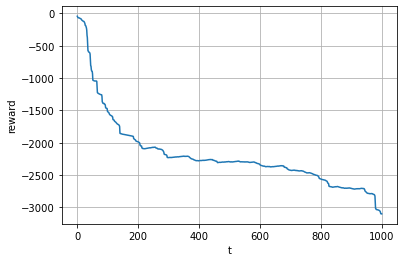

In [31]:
pd.Series(rewards).cumsum().plot(grid=True,ylabel="reward",xlabel="t")

<AxesSubplot:xlabel='t', ylabel='reward'>

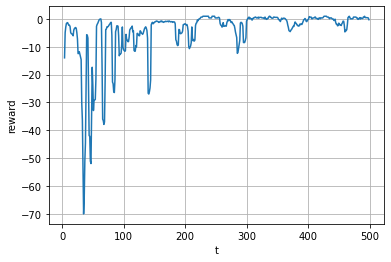

In [25]:
pd.Series(rewards)[:500].rolling(5).mean().plot(grid=True,ylabel="reward",xlabel="t")

In [ ]:
episode_scores = []
rewards = []
save=False

In [14]:

for episode in range(1):
    env = Environment()
    env.start_sim()
    state = env.get_state()
    state = tuple(state[0])
    score = 0
    for i in tqdm(range(700)):
        state = np.where(np.array([state]) > .01, 1, 0)
        state = tuple(state[0])
        if state not in viable_states:
            viable_states.append(state)
            for action in viable_actions:
                Q[(state, action)] = 10.
        action = choice(state)
        next_state, reward, _ = env.step(action)
        next_state = np.where(next_state > .01, 1, 0)
        next_state = tuple(next_state[0])
        if next_state not in viable_states:
            viable_states.append(next_state)
            for action in viable_actions:
                Q[(next_state, action)] = 10.
        Q[(state, action)] += alpha*(reward + gamma*Q[(next_state, choice(next_state))] - Q[(state, action)] )
        state = next_state
        score += reward
        rewards.append(reward)
    episode_scores.append(score)
    env.end_sim()
    env.disconnect()
    if save:
        with open("./QLearner/viable_states_%s" % episode, "wb") as f:
            pickle.dump(viable_states, f)
        with open("./QLearner/policy_%s" % episode, "wb") as f:
            pickle.dump(policy, f)
        with open("./QLearner/qtable_%s" % episode, "wb") as f:
            pickle.dump(Q, f)



Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 700/700 [06:37<00:00,  1.76it/s]


In [13]:
env.move(-20,-20,400)